In [2]:
from matplotlib import pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry as shp
from shapely.geometry import Point
from shapely.validation import explain_validity
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable



# import contextily as ctx


CRS_LAT_LON = "epsg:4326"
# CRS_WGS84 = "EPSG:32719"
CRS_WGS84 = "EPSG:3857"
CRS_CHILE19S = "EPSG:20049"

# Interpolación de datos de acuerdo a IDWR
Si se quiere cambiar el método de interpolación se debe simplemente modificar la forma en que se obtienen los values

In [2]:
from scipy.spatial import distance_matrix
from math import log
# Inverse distance weighted
def idwr2(x, y, z, xi, yi,n):
    #xi,yi: puntos donde queremos estimar z
    #x,y,z: observaciones
    points=np.array([[x,y] for x,y, in zip(x,y)]) 
    
    lstzi=[]
    for p in range(len(xi)):
        lstdist = [] #lista donde guardamos las distancias a todos los puntos observados
        #iteramos sobre los elementos de los vectores (x,y,z)
        dists=distance_matrix([[xi[p], yi[p]]],points)
        
        weights=1/np.power(dists, n)
        zi = np.sum(np.array(z)*weights)/np.sum(weights)
        lstzi.append(zi)
    return(np.array(lstzi))

In [29]:
def make_grid(comunas, n_resolutionx=100, n_resolutiony=500):
    x_min = comunas.geometry.x.min()
    x_max = comunas.geometry.x.max()
    y_min = comunas.geometry.y.min()
    y_max = comunas.geometry.y.max()
    grid_x, grid_y = np.mgrid[x_min:x_max:(x_max-x_min)/n_resolutionx, y_min:y_max:(y_max-y_min)/n_resolutiony]
    return grid_x, grid_y

def plot_interpolation(grid_x, grid_y, z_values, geometry_bound, name_graph, cmap='viridis'):
    ig,ax=plt.subplots(1,1,figsize=(15,15))
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad="2%")
    im=ax.contourf(grid_x,grid_y,z_values, 1000, cmap=cmap, origin='lower')
    geometry_bound.boundary.plot(ax=ax,color='k',lw=0.3)
    ax.set_yticklabels([])
    
    ax.set_xticklabels([])
    ax.set_aspect('equal')
    # ax.set_title(name_graph)
    plt.colorbar(im,cax=cax);

# Aplicar interpolación

In [3]:
colegios = pd.read_csv('tsp/Nuevo TSP/colegios_final.csv', sep=',')
geometry_column = gpd.GeoSeries.from_wkt(colegios.geometry)
colegios = gpd.GeoDataFrame(data=colegios, geometry=geometry_column, crs=CRS_CHILE19S)

In [31]:
colegios = pd.read_parquet('../Solution1/data_final.parquet', columns=['RBD', 'X', 'Y', 'Aristas', 'Logistica','Manipuladora', 'Beneficio', 'Alimentos', 'Raciones', 'Profit', 'UT', 'geometry'])
geometry = [Point(xy) for xy in zip(colegios.X/10**5, colegios.Y/10**5)]
colegios_gpd = gpd.GeoDataFrame(colegios, crs=CRS_CHILE19S, geometry=geometry)

In [14]:
comunas = gpd.read_file("comunas_fixed/comunas_fixed.shp")

In [15]:
comunas_proyected = comunas.to_crs(CRS_CHILE19S)

In [9]:
grid_x, grid_y = make_grid(colegios[colegios['value']<200000], n_resolutionx=100, n_resolutiony=10000) # La resolución es en gran medida lo que acota el tiempo de ejecución.
# Para obtener resultados rápidos se puede simplemente bajar la resolución


In [34]:
values_idw=idwr2(colegios[colegios['value']<200000]["x"], colegios[colegios['value']<200000]["y"], colegios[colegios['value']<200000]['value'], grid_x.flatten(), grid_y.flatten(), 2)
z_idw=np.reshape(values_idw,grid_x.shape)

In [35]:
z_idw=np.reshape(values_idw,grid_x.shape)

In [37]:
from scipy.interpolate import griddata

colegios_aux = colegios[colegios['value']<200000]
x = colegios_aux.geometry.x
y = colegios_aux.geometry.y
points=np.array([[x_aux,y_aux] for x_aux,y_aux, in zip(x, y)])
values = np.array([z for z in colegios_aux["value"]])
z_vor = griddata(points, values, (grid_x, grid_y), method='nearest')


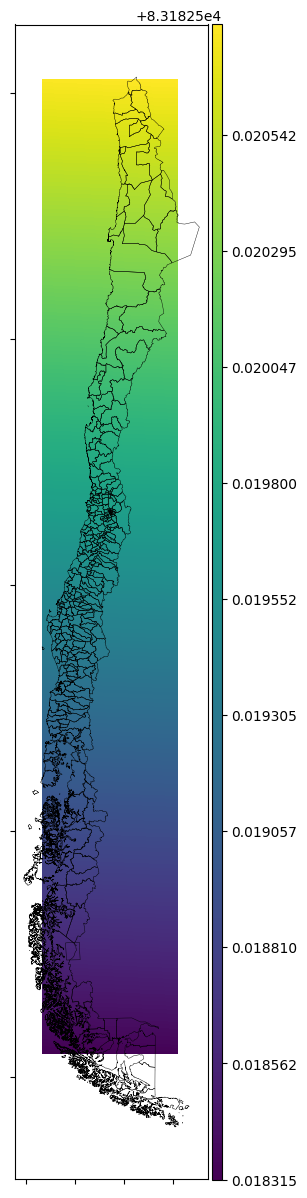

In [38]:
plot_interpolation(grid_x, grid_y, z_idw, geometry_bound=comunas_proyected,name_graph='Interpolación', cmap='viridis')

In [35]:
from math import log
def show_schools_and_comunas(comunas, colegios, name_graph, column_name):


    fig,ax=plt.subplots(1,1,figsize=(15,15))

    colegios[f'log_{column_name}'] = colegios[column_name].apply(lambda x: log(x))  # Apply log transformation

    colegios.plot(ax=ax, column=f'log_{column_name}', cmap='viridis', legend=True, markersize=10)


    # colegios['value','geometry'].plot(ax=ax, cmap='viridis', legend=True)
    comunas.boundary.plot(ax=ax,color='k',lw=0.2)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.legend([])
    # ax.plot(grid_x, grid_y, marker='.', markersize=1,color='k', linestyle='none')


c:\Users\minso\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


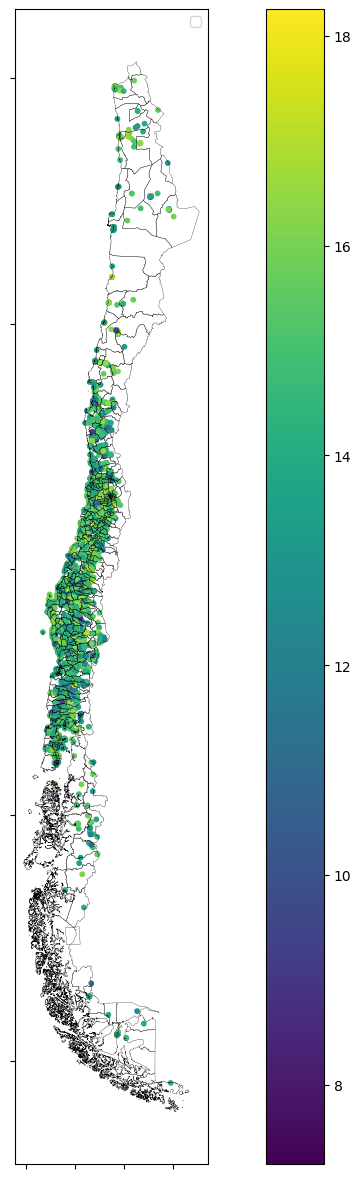

In [42]:
column_name = 'Profit'
threshold_h = 100*10**7
threshold_b = 0
colegios_filtered = colegios_gpd[(threshold_b<=colegios_gpd[column_name]) & (colegios_gpd[column_name]<=threshold_h)]
show_schools_and_comunas(comunas_proyected, colegios_filtered, name_graph='Colegios puntuales', column_name='Profit')